## Discrete-Discrete HMM from scratch

For references check:
- Hidden Markov models and dynamical systems (Andrew M. Fraser)

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dc

## Test data preparation

### Simulated problem
Problem parameters
- n_states = 2
- p_0 = {0: 1/4, 1: 1/2, 2: 1/4}
- p_1 = {-1: 1/2, 1: 1/5, 2: 3/10}
- p00 = 0.8
- p11 = 0.9

In [2]:
p_0 = {0: 1/4, 1: 1/2, 2: 1/4}
p_1 = {-1: 1/2, 1: 1/5, 2: 3/10}
p00=0.8
p11=0.9

N = 100

In [13]:
x = np.zeros(N)
s = np.zeros(N)
s[0] = 0

def random_draw(p):
    cumprob=0
    r = np.random.rand()
    for k in p.keys():
        cumprob += p[k]
        if r<cumprob:
            return k
            
x[0] = random_draw(p_0)

for i in range(1,N-1):
    r = np.random.rand()
    if s[i] == 0:
        x[i] = random_draw(p_0)
        if r > p00:
            s[i+1] = 1
        else:
            s[i+1] = s[i]
    else:
        x[i] = random_draw(p_1)
        if r > p11:
            s[i+1] = 0
        else:
            s[i+1] = 1
if s[-1] == 0:
    x[-1] = random_draw(p_0)
else:
    x[-1] = random_draw(p_1)

<bound method Figure.show of <Figure size 432x288 with 2 Axes>>

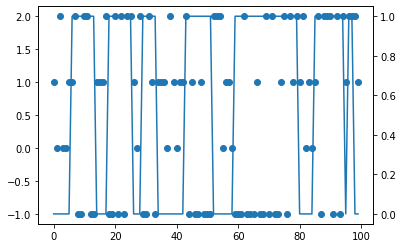

In [14]:
fig,ax = plt.subplots()
ax.scatter(np.arange(N),x)
ax2 = ax.twinx()
ax2.plot(np.arange(N),s)
fig.show

## Algorithms

### Forward Algorithm

In [76]:
# Parameters
ss = np.array([0,1]).astype(int)
ps0 = [0.5,0.5]
pys = [{-1: 0.1, 0: 0.25, 1: 0.4, 2: 0.25},{-1: 0.5, 0: 0.1, 1: 0.3, 2: 0.1}]
p00=0.8
p11=0.9
pss = [{0:p00, 1:1-p00},{0:1-p11, 1:p11}]
y = x.astype(int)
N = 100

In [88]:
alfas = np.full([2,N],np.nan)
gammas = np.full(N,np.nan)
t = 0
for state in ss:
    alfas[state,t] = ps0[state]*pys[state][y[t]]/sum(ps0[s]*pys[s][y[t]] for s in ss)
gammas[t] = 0

t += 1
aux = np.full(2,np.nan)
for state in ss:
    aux[state] = pys[state][y[t]]*alfas[state,t-1]
gammas[t] = sum(aux[state] for state in ss)
for state in ss:
    alfas[state,t] = aux[state]/gammas[t]
gammas

array([0.        , 0.18571429,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [94]:
t += 1
for state in ss:
    alfas[state,t-1] = sum(pss[s][state]*alfas[s][t-1] for s in ss)
for state in ss:
    aux[state] = pys[state][y[t]]*alfas[state,t-1]
gammas[t] = sum(aux[state] for state in ss)
for state in ss:
    alfas[state,t] = aux[state]/gammas[t]
gammas

array([0.        , 0.18571429, 0.19315385, 0.19881004, 0.20146131,
       0.36098936, 0.35665777, 0.18887203,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [101]:
def FA(y,ps0,pys,pss):
    """
    y: np.array(observations).astype(int)
    ps0: np.array(initial state probabilities)
    pys: vector of dictionaries containing the probability for each y given s. E.g. [{3:0.4, 4:0.6},{3:0.9, 4:0.1}]. Both dictionaries must contain the same keys
    pss: vector of dictionaries containing the state transition probabilities
    """
    N = y.shape[0]
    n_states = ps0.shape[0]
    ss = np.arange(n_states)

    alfas = np.full([n_states,N],np.nan)
    gammas = np.full(N,np.nan)
    t = 0
    for state in ss:
        alfas[state,t] = ps0[state]*pys[state][y[t]]/sum(ps0[s]*pys[s][y[t]] for s in ss)
    gammas[t] = 1

    t += 1
    aux = np.full(2,np.nan)
    for state in ss:
        aux[state] = pys[state][y[t]]*alfas[state,t-1]
    gammas[t] = sum(aux[state] for state in ss)
    for state in ss:
        alfas[state,t] = aux[state]/gammas[t]


    for t in range(2,N):
        for state in ss:
            alfas[state,t-1] = sum(pss[s][state]*alfas[s][t-1] for s in ss)
            aux[state] = pys[state][y[t]]*alfas[state,t-1]
        gammas[t] = sum(aux[state] for state in ss)
        for state in ss:
            alfas[state,t] = aux[state]/gammas[t]
    
    p = np.exp(np.sum(np.log(gammas))) # summing logs instead of multiplying probabilities to avoid underflow. Probability of y(0) ignored
    return p,alfas,gammas

### Backward Algorithm

In [103]:
# Parameters
ss = np.array([0,1]).astype(int)
n_states = 2
ps0 = np.array([0.5,0.5])
pys = [{-1: 0.1, 0: 0.25, 1: 0.4, 2: 0.25},{-1: 0.5, 0: 0.1, 1: 0.3, 2: 0.1}]
p00=0.8
p11=0.9
pss = [{0:p00, 1:1-p00},{0:1-p11, 1:p11}]
y = x.astype(int)
N = 100

In [116]:
_, alfas, gammas = FA(y, ps0, pys,pss)
betas = np.full([n_states,N],np.nan)
t = N-1
for s in ss: betas[s,t] = 1

In [119]:
for state in ss:
    betas[state,t-1] = sum(betas[s,t]*pys[s][y[t]]*pss[state][s]/gammas[t] for s in ss)
t -= 1

In [124]:
def BA(y,ps0,pys,pss):
    """
    y: np.array(observations).astype(int)
    ps0: np.array(initial state probabilities)
    pys: vector of dictionaries containing the probability for each y given s. E.g. [{3:0.4, 4:0.6},{3:0.9, 4:0.1}]. Both dictionaries must contain the same keys
    pss: vector of dictionaries containing the state transition probabilities
    """
    N = y.shape[0]
    n_states = ps0.shape[0]
    ss = np.arange(n_states)

    _, _, gammas = FA(y,ps0,pys,pss)
    betas = np.full([n_states,N],np.nan)
    for s in ss: betas[s,N-1] = 1

    for t in range(N-1,-1,-1):
        for state in ss:
            betas[state,t-1] = sum(betas[s,t]*pys[s][y[t]]*pss[state][s]/gammas[t] for s in ss)
    
    return betas

### Viterbi Algorithm

In [143]:
def u_log(y,t,s_historic,ps0,pss):
    N = s_historic.shape[0]
    if len(s_historic) = 1:

    t1 = sum(np.log([pss[s_historic[i-1]][s_historic[i]] for i in range(1,N)]))
    t2 = sum(np.log([pys[s_historic[i]][y[i]] for i in range(N)]))
    

    return t1+t2

In [177]:
v = np.full([n_states,N],np.nan)
w = np.full([n_states,n_states,N],np.nan)
B = np.full([n_states,N],np.nan)

for s in ss:
    v[s,0] = pys[s][y[0]]
t = 0


In [187]:
for t in range(1,N):
    for s_new in ss:
        best = -np.Inf
        best_s = np.nan
        for s_old in ss:
            w[s_old,s_new,t] = v[s_old,t-1] + np.log(pss[s_old][s_new]) + np.log(pys[s_new][y[t]])
            if w[s_old,s_new,t] > best: 
                best = w[s_old,s_new,t]
                best_s = s_old
        
        B[s_new,t] = best_s
        v[s_new,t] = w[best_s,s_new,t]
s_opt = np.full(N,np.nan).astype(int)
s_opt[t] = np.argmax(v[:,-1])
for t in range(N-2,-1,-1):
    s_opt[t] = B[s_opt[t+1],t+1]
s_opt


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [188]:
def VA(y,pys,pss):
    N = y.shape[0]
    n_states = len(pss)
    v = np.full([n_states,N],np.nan)
    w = np.full([n_states,n_states,N],np.nan)
    B = np.full([n_states,N],np.nan)

    for s in ss:
        v[s,0] = pys[s][y[0]]

    for t in range(1,N):
        for s_new in ss:
            best = -np.Inf
            best_s = np.nan
            for s_old in ss:
                w[s_old,s_new,t] = v[s_old,t-1] + np.log(pss[s_old][s_new]) + np.log(pys[s_new][y[t]])
                if w[s_old,s_new,t] > best: 
                    best = w[s_old,s_new,t]
                    best_s = s_old
            
            B[s_new,t] = best_s
            v[s_new,t] = w[best_s,s_new,t]
    s_opt = np.full(N,np.nan).astype(int)
    s_opt[t] = np.argmax(v[:,-1])
    for t in range(N-2,-1,-1):
        s_opt[t] = B[s_opt[t+1],t+1]
    return s_opt
VA(y,pys,pss)    

AttributeError: 'list' object has no attribute 'shape'

## Recursive functions

In [250]:
ss = [0,1]
mus = [-1,1]
stds = [1,0.7]
p0s=[0.6,0.4]
p00 = 0.8
p11 = 0.9
P = np.array([[p00,1-p00],[1-p11,p11]])

In [251]:
def prob_within(x,mu,std):
    return 2-2*norm.cdf(x,mu,std)

def g(x,s,mus,stds):
    return prob_within(x,mus[s],stds[s])

def p(x,mus,stds):
    return sum(g(x,s,mus,stds)*p0s[s] for s in ss)

def F0(s0,x0,mus,stds):
    return p0s[s0]*g(x0,s0,mus,stds)/p(x0,mus,stds)

def q(s0,s1,P):
    return P[s0,s1]

def F_step(s0,s1,x0,mus,stds,P):
    return sum(q(s0,s1,P)*F0(s0,x0,mus,stds) for s0 in ss)

def p_x1_x0(x0,x1,s1,mus,stds,P):
    return sum(g(x1,s,mus,stds)*F_step(s,s1,x0,mus,stds,P) for s in ss)

/home/fcelaya/quant/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


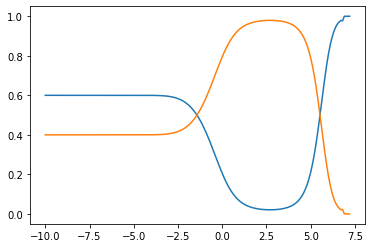

In [226]:
# Likelihood that state is certain state depending on observation value
x_axis = np.arange(-10,10,0.1)
fig,ax = plt.subplots()
ax.plot(x_axis,[F0(0,i,mus,stds) for i in x_axis])
ax.plot(x_axis,[F0(1,i,mus,stds) for i in x_axis])

## MC methods

In [252]:
np.random.seed(42)
P = np.array([[0.6,0.15,0.25],[0.2,0.7,0.1],[0.0,0.2,0.8]])
S = 3
N = 100

In [234]:
def create_chain(P,N,s0=0):
    if P.shape[0] != P.shape[1]:
        raise ValueError("Transition matrix must by of nxn size")
    else:
        S = P.shape[0]
    
    s = np.zeros(N).astype(int)
    s[0] = s0
    for i in range(1,N):
        probs = P[s[i-1]]
        r = np.random.rand()
        j = 0
        while True:
            if r < np.sum(probs[:j+1]):
                s[i] = j
                break
            else:
                j += 1
    return s

mc = create_chain(P,1000)

In [235]:
def estimate_transition_matrix(x):
    """
    Only accepts input state vector with states: 0, 1, 2, 3, etc.
    """
    n = np.unique(x).size

    P = np.array([np.zeros(n) for i in range(n)])

    for i in range(1,x.shape[0]):
        P[x[i-1],x[i]] += 1
    
    for i in range(n):
        P[i] = P[i]/np.sum(P[i])

    return P

## Recursive parameter estimation

In [260]:
# Create initial parameter guess
P = np.array([[0.7,0.3],[0.3,0.7]])
mu1 = 1
mu0 = 0
std1 = 1
std0 = 0
N = x.shape[0]

In [261]:
# Create random initial state chain
mc_states = create_chain(P,N,0)
# Create sub chains for data in each state
x_s0 = x[mc_states==0]
x_s1 = x[mc_states==1]
# Find parameters for each state
d0 = norm.fit(x_s0)
d1 = norm.fit(x_s1)
# Estimate likelihood for each point being in a certain state
def likelihood(x,s,d0,d1):
    mus = [d0[0],d1[0]]
    stds = [d0[1],d1[1]]
    return F0(s,x,mus,stds)

mc_states = np.zeros(N).astype(int)
for i in range(N):
    if likelihood(x[i],0,d0,d1) > likelihood(x[i],1,d0,d1):
        mc_states[i] = 0
    else:
        mc_states[i] = 1

P = estimate_transition_matrix(mc_states)
print(P)

[[1.]]


In [220]:
mc_states

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [192]:
likelihood(1,d1)

0.4157295514763035